In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Preparing the dataset

In [46]:
plt.rcParams['figure.figsize'] = 10, 5
pd.set_option('display.max_columns', None)

objects = pd.read_csv('./startup-investments/objects.csv')
objects.describe()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,entity_id,logo_width,logo_height,investment_rounds,invested_companies,funding_rounds,funding_total_usd,milestones,relationships
count,462651.000000,462651.000000,462651.000000,462651.000000,462651.000000,462651.000000,4.626510e+05,462651.000000,462651.000000
mean,132915.761775,189.159799,130.488664,0.173939,0.138132,0.113749,8.926722e+05,0.265196,1.794305
std,88768.946816,432.403482,337.191612,3.637983,2.549245,0.524229,1.700120e+07,0.568577,5.456711
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,45249.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,143072.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000
75%,213868.500000,216.000000,139.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000
max,286215.000000,18200.000000,9600.000000,529.000000,459.000000,15.000000,5.700000e+09,9.000000,1189.000000


In [48]:
# select relevant columns
df_objects = objects[['id', 'name', 'entity_type', 'category_code', 'status', 'founded_at', 'country_code', 'first_investment_at',
                      'last_investment_at',	'investment_rounds',	'invested_companies',	'first_funding_at',	'last_funding_at', 'funding_rounds', 'funding_total_usd']]

# only select Companies (get rid of people or other entities)
df_companies = df_objects.loc[df_objects['entity_type'] == 'Company']
df_companies = df_companies.drop('entity_type', axis=1)

df_companies = df_companies.dropna()
df_companies.columns


Index(['id', 'name', 'category_code', 'status', 'founded_at', 'country_code',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd'],
      dtype='object')

## Top 15 startup categories

Total start-ups: 213


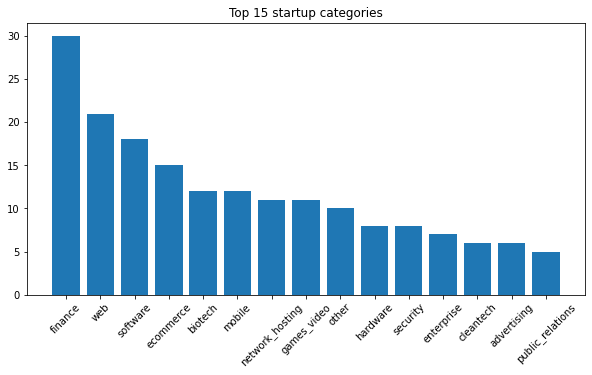

<Figure size 720x360 with 0 Axes>

In [63]:
print('Total start-ups:', len(df_companies))

height = df_companies['category_code'].value_counts()[:15]
bars = df_companies['category_code'].value_counts()[:15].index
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xticks(rotation=45)
plt.title("Top 15 startup categories")
plt.show()


## Funding distribution

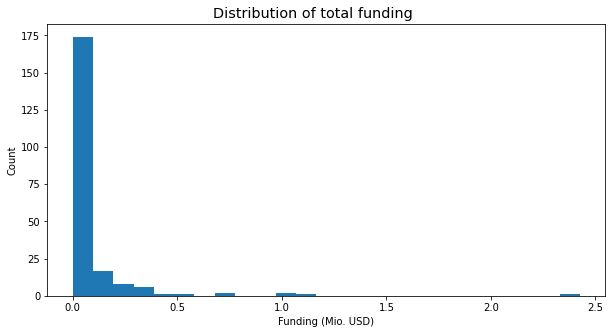

In [50]:
plt.hist(df_companies['funding_total_usd'].dropna() / 1000000000, bins=25)
plt.ylabel('Count')
plt.xlabel('Funding (Mio. USD)')
plt.title("Distribution of total funding ", fontdict=None,
          position=[0.48, 1.05], size='x-large')
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()


### Removing outliers

We use IQR to remove outliers.

In [51]:
# Remove outliers

# Remove organizations w/o funding
df_companies_o = df_companies[(df_companies['funding_total_usd'] > 0)]

# Calculate IQR
Q1 = df_companies_o['funding_total_usd'].quantile(0.25)
Q3 = df_companies_o['funding_total_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = (Q1 - 1.5 * IQR)
upper_bound = (Q3 + 1.5 * IQR)

without_outliers = df_companies_o[(df_companies_o['funding_total_usd'] > lower_bound) & (
    df_companies_o['funding_total_usd'] < upper_bound)]

print('Ignored', len(df_companies) - len(without_outliers), 'outliers')

Ignored 47 outliers


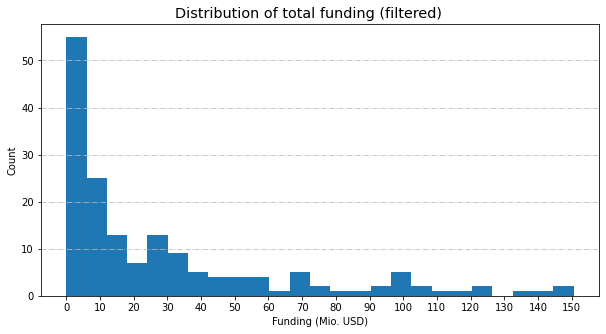

25% of funded organizations get 4 Mio. USD or less.
50% of funded organizations get 13 Mio. USD or less.
75% of funded organizations get 40 Mio. USD or less.
-> Only 5% of funded organizations get more than 106 Mio. USD.


In [66]:
x = without_outliers['funding_total_usd'].dropna() / 1000000
plt.hist(x, bins=25)
plt.gca().yaxis.grid(True, linestyle="-.", color="#BBB")
plt.xticks(np.arange(min(x), max(x)+1, 10.0))
plt.ylabel('Count')
plt.xlabel('Funding (Mio. USD)')
plt.title("Distribution of total funding (filtered)",
          fontdict=None, position=[0.48, 1.05], size='x-large')
plt.show()

q_1 = without_outliers['funding_total_usd'].quantile(0.25) / 1000000
q_2 = without_outliers['funding_total_usd'].quantile(0.5) / 1000000
q_3 = without_outliers['funding_total_usd'].quantile(0.75) / 1000000
q_95 = without_outliers['funding_total_usd'].quantile(0.95) / 1000000

print('25% of funded organizations get', int(q_1), 'Mio. USD or less.')
print('50% of funded organizations get', int(q_2), 'Mio. USD or less.')
print('75% of funded organizations get', int(q_3), 'Mio. USD or less.')
print('-> Only 5% of funded organizations get more than', int(q_95), 'Mio. USD.')


## Funding per category

In [53]:
categories = df_companies.groupby(by='category_code').sum()
categories['relative_funding'] = categories['funding_total_usd'] / df_companies['category_code'].value_counts()
categories.sort_values(by='funding_total_usd', ascending=False, inplace=True)
categories.head(5)

,investment_rounds,invested_companies,funding_rounds,funding_total_usd,relative_funding
category_code,,,,,
web,67,58,44,2.806821e+09,1.336581e+08
social,100,83,17,2.471950e+09,8.239833e+08
hardware,17,13,13,1.589627e+09,1.987034e+08
software,42,38,33,1.287818e+09,7.154544e+07
games_video,23,20,20,1.206460e+09,1.096782e+08


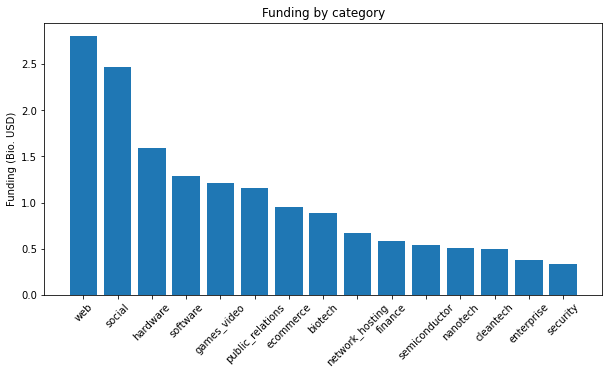

Place #1: category "web" got 16 % of the total funding.
Place #2: category "social" got 14 % of the total funding.
Place #2: category "hardware" got 9 % of the total funding.


In [54]:
bars = categories[:15].index
y_pos = np.arange(len(bars))
plt.bar(y_pos, categories['funding_total_usd'][:15] / 1000000000)
plt.xticks(y_pos, bars)
plt.xticks(rotation=45)
plt.ylabel('Funding (Bio. USD)')
plt.title("Funding by category")
plt.show()

funding_total = categories['funding_total_usd'].sum()

funding_web = categories[(categories.index == 'web')]['funding_total_usd'].values[0] 
print('Place #1: category "web" got', round(funding_web/funding_total * 100), '% of the total funding.')

funding_social = categories[(categories.index == 'social')]['funding_total_usd'].values[0] 
print('Place #2: category "social" got', round(funding_social/funding_total * 100), '% of the total funding.')

funding_hardware = categories[(categories.index == 'hardware')]['funding_total_usd'].values[0] 
print('Place #2: category "hardware" got', round(funding_hardware/funding_total * 100), '% of the total funding.')

### Relative funding by category
Relativ funding = Funding per category / No. of startups per category

In [55]:
categories_rel = categories.sort_values(by='relative_funding', ascending=False)

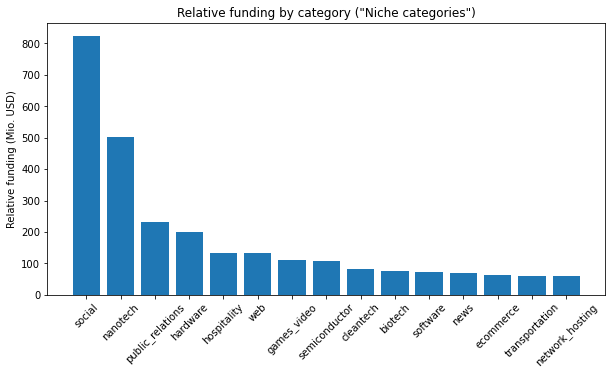

In [56]:

bars = categories_rel[:15].index
y_pos = np.arange(len(bars))
plt.bar(y_pos, categories_rel['relative_funding'][:15] / 1000000)
plt.xticks(y_pos, bars)
plt.xticks(rotation=45)
plt.ylabel('Relative funding (Mio. USD)')
plt.title('Relative funding by category ("Niche categories")')
plt.show()

# Founding dates

In [57]:

df_companies['founded_at'] = pd.to_datetime(
    df_companies['founded_at'], errors='coerce')
top3 = df_companies.sort_values(
    by='funding_total_usd', ascending=False).head(3)
top3[['name', 'founded_at', 'funding_total_usd']]


,name,founded_at,funding_total_usd
161551,Facebook,2004-02-01,2.425700e+09
2225,Groupon,2008-11-11,1.147288e+09
163774,Blackberry,1984-01-01,1.000000e+09


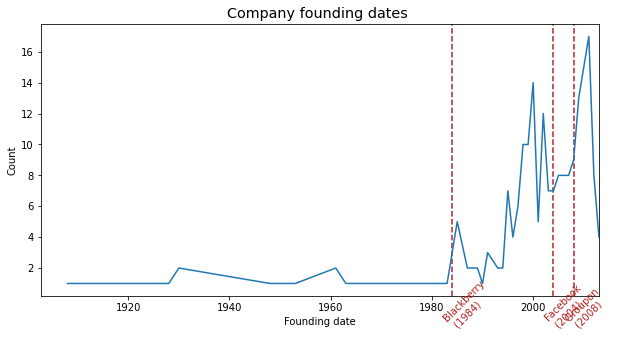

In [58]:
# Draw lines of top 3 companies
for index, company in top3.iterrows():
    year = company['founded_at'].year
    name = company['name']
    plt.axvline(x=year, color='firebrick', linestyle="--")
    plt.text(x=year-2, y=-2, s=f'{name} \n ({year})', rotation=45, color='firebrick')

# Plot founding dates
df_companies['name'].groupby(
    df_companies["founded_at"].dt.year).count().plot(kind="line")
plt.ylabel('Count')
plt.xlabel('Founding date')
plt.title("Company founding dates ", fontdict=None, size='x-large')
plt.xlim(right=2013)
plt.show()


# Correlations
The following graphs show that there are no real correlations in the dataset.

In [59]:
# select interesting columns
df_objects_c = objects[['entity_type', 'founded_at', 'funding_total_usd', 'investment_rounds', 'invested_companies', 'milestones', 'relationships']]

# only select Companies (get rid of people or other entities)
df_companies_c = df_objects_c.loc[df_objects_c['entity_type'] == 'Company']
df_companies_c = df_companies_c.drop('entity_type', axis=1)

df_companies_c = df_companies_c.dropna()
df_companies_c.columns

Index(['founded_at', 'funding_total_usd', 'investment_rounds',
       'invested_companies', 'milestones', 'relationships'],
      dtype='object')

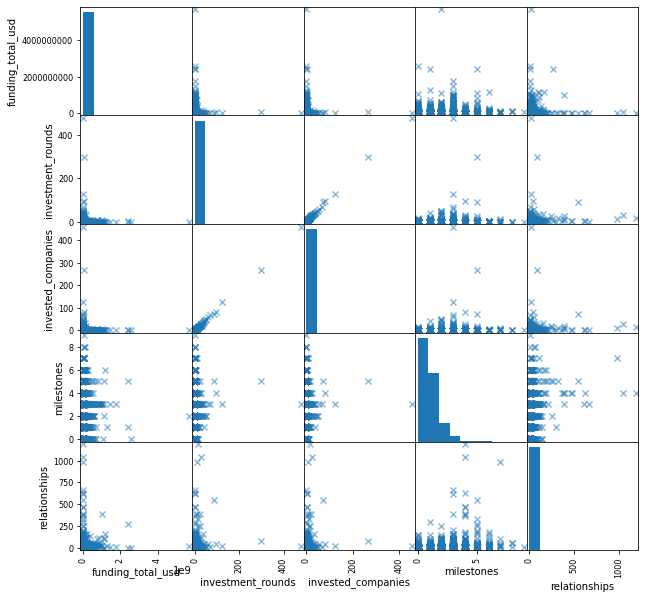

In [60]:
plot = pd.plotting.scatter_matrix(df_companies_c, figsize=(10, 10), marker='x')

<AxesSubplot:>

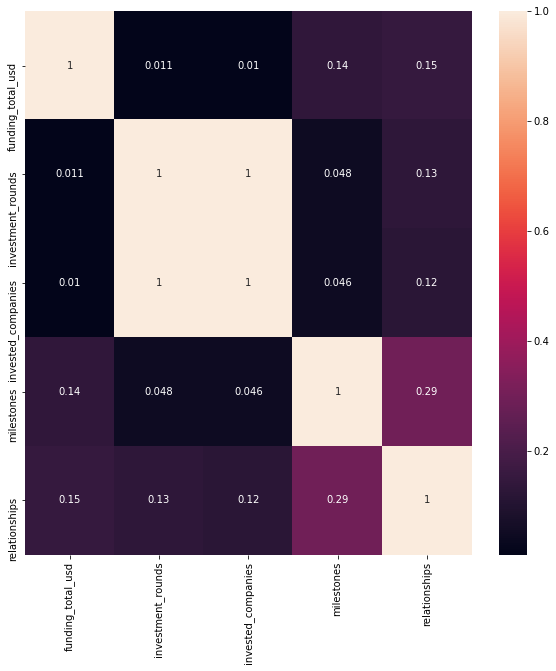

In [61]:
corr = df_companies_c.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, annot=True)
